<h1 style="text-align: center;">EECE 7150 HW2</h1>

<h3 style="text-align: center;">Joy Fakhry</h3>
<h3 style="text-align: center;">002968034</h3>

# 1) Put image 2 onto image 1

To begin, we will select four points from each image. For image two (the source image), we will select the outer corner pixels, starting from the top left and going around clockwise. For image one (the target image), we will use matplotlib.pyplot.ginput to select the inner corners of the picture frame, again starting in the upper left corner and going clockwise. 

As a note, we will compute the homography using the Direct Linear Transformation algorithm as found in chapter 4 of Multiple View Geometry.

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

img1 = cv2.imread('HW2_image1.jpg')  # picture frame
img2 = cv2.imread('HW2_image2.jpg')  # image to place on painting

# src_pts and dst_pts correspond to the x_i and x_i' in homogeneous coordinates

# corner points of source image
src_pts = np.array([
    (0, 0, 1),
    (img2.shape[1], 0, 1),
    (img2.shape[1], img2.shape[0], 1),
    (0, img2.shape[0], 1),
])

# inner corners of picture frame, taken from plt.ginput
dst_pts = np.array([
    (532, 500, 1),
    (933, 461, 1),
    (960, 1147, 1),
    (565, 1092, 1)
])

Creating the A matrix

In [2]:
# Initialize A matrix. Since we have 4 points, A has size 2*4 x 9

def create_A(src_pts, dst_pts):
    num_points = len(src_pts)
    A = np.zeros((2*num_points, 9))
    
    for row in range(num_points):
        x_i = src_pts[row].T
        x_i_prime = dst_pts[row].T

        A[row*2][3:6] = -x_i.T
        A[row*2][6:9] = x_i_prime[1]*x_i.T
        A[row*2+1][0:3] = x_i.T
        A[row*2+1][6:9] = -x_i_prime[0]*x_i.T
    
    return A

A = create_A(src_pts, dst_pts)

np.set_printoptions(suppress=True, linewidth=200)
print(A)

[[      0.       0.       0.       0.       0.      -1.       0.       0.     500.]
 [      0.       0.       1.       0.       0.       0.       0.       0.    -532.]
 [      0.       0.       0.    -450.       0.      -1.  207450.       0.     461.]
 [    450.       0.       1.       0.       0.       0. -419850.       0.    -933.]
 [      0.       0.       0.    -450.    -446.      -1.  516150.  511562.    1147.]
 [    450.     446.       1.       0.       0.       0. -432000. -428160.    -960.]
 [      0.       0.       0.       0.    -446.      -1.       0.  487032.    1092.]
 [      0.     446.       1.       0.       0.       0.       0. -251990.    -565.]]


Now that we have the A matrix, we can perform SVD on it and obtain the homography matrix from V.

In [3]:
def computeH(A):
    U, D, V = np.linalg.svd(A)

    # the homography matrix is obtained from the last column of V
    H = V.T[:, -1]

    # we reshape the H vector into a 3x3 matrix
    H = np.reshape(H, (3, 3))

    # normalize H so that the last element is equal to 1
    H = H/H[2, 2]

    return H

H = computeH(A)
print(H)

[[  0.60290558   0.10527067 531.99999999]
 [ -0.22907047   1.38780978 500.        ]
 [ -0.0003089    0.00005536   1.        ]]


We can compare this homography with the findHomography function from OpenCV to see if they match.

In [4]:
# checking H
h, status = cv2.findHomography(src_pts, dst_pts)
print(h)

[[  0.60290558   0.10527067 532.        ]
 [ -0.22907047   1.38780978 500.        ]
 [ -0.0003089    0.00005536   1.        ]]


They match, so now we can use warpPerspective to transform the painting to fit within the picture frame.

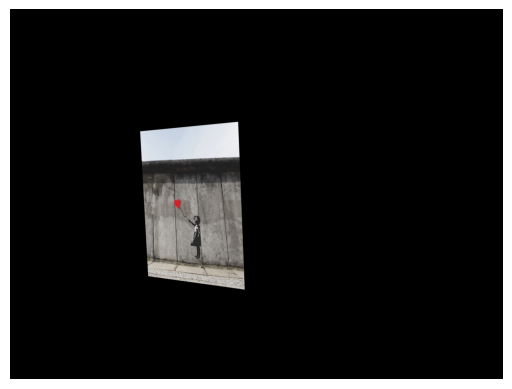

In [5]:
img2_warped = cv2.warpPerspective(img2, H, (img1.shape[1], img1.shape[0]))
cv2.imwrite('Part 1 Images/warped.png', img2_warped)

img2_warped_rgb = cv2.cvtColor(img2_warped, cv2.COLOR_BGR2RGB)

plt.imshow(img2_warped_rgb)
plt.axis('off')
plt.show()

Now we will paste this source image onto the picture frame target using PIL.

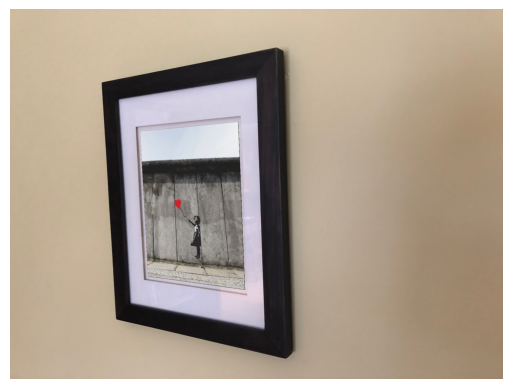

In [6]:
from PIL import Image, ImageDraw, ImageOps

# load images into Pillow format
foreground = Image.open("Part 1 Images/warped.png")
background = Image.open("HW2_image1.jpg")

# create a mask using the picture frame coordinates (dst_pts)
mask_im = Image.new("L", foreground.size, 0)
draw = ImageDraw.Draw(mask_im)
mask_poly = [(i[0], i[1]) for i in dst_pts]
draw.polygon(mask_poly, fill=255)

# because of format differences, we need to flip and mirror the background image first, 
# then paste the foreground (warped painting) onto it, using the polygon we created as a mask
background = ImageOps.mirror(background)
background = ImageOps.flip(background)
background.paste(foreground, (0,0), mask=mask_im)

# show and save the image
plt.imshow(background)
plt.axis('off')
plt.show()

background = background.rotate(180) # rotate the image back so we see it right side up
background.save("Part 1 Images/Part_1_Combined_Image.png")

# 2) Computing Homography with 8 Points

To start, we need to select 8 points. We will use 4 corner points, as before, as well as the midpoints of the edges connecting those points. This way the point correspondences will still match. To compute the midpoint, we simply take the average of the verticies that edge is made of. The image below is the new source image we will use.

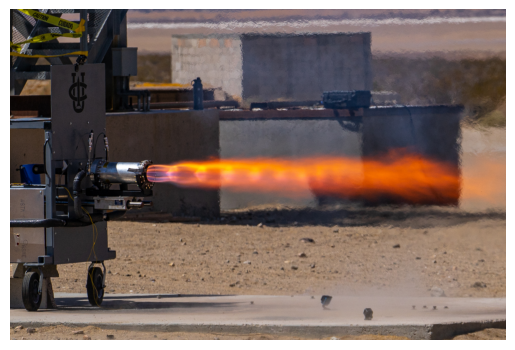

In [7]:
img3 = cv2.imread('Part 2 Images/STF3 Fire-5.jpeg') # new source image

image_rgb = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis('off')
plt.show()

Below, we pick the midpoints between the verticies of the previously selected corners and combine them so they appear in an array sequentially.

In [8]:
src_corners = np.array([
    (0, 0, 1),
    (img3.shape[1], 0, 1),
    (img3.shape[1], img3.shape[0], 1),
    (0, img3.shape[0], 1),
])

src_midpoints = np.array([
    (src_corners[0]+src_corners[1])/2,
    (src_corners[1]+src_corners[2])/2,
    (src_corners[2]+src_corners[3])/2,
    (src_corners[3]+src_corners[0])/2
])

# a function to sequentially combine the corner and midpoints into one array
def zipper(corners, midpoints):
    output = []

    for i in range(len(corners)):
        output.append(corners[i])
        output.append(midpoints[i])
    
    return np.array(output)

src_pts_part2 = zipper(src_corners, src_midpoints)

dst_corners = np.array([
    (532, 500, 1),
    (933, 461, 1),
    (960, 1147, 1),
    (565, 1092, 1)
])

dst_midpoints = np.array([
    (dst_pts[0]+dst_pts[1])/2,
    (dst_pts[1]+dst_pts[2])/2,
    (dst_pts[2]+dst_pts[3])/2,
    (dst_pts[3]+dst_pts[0])/2
])

dst_pts_part2 = zipper(dst_corners, dst_midpoints)

print("8 source points from new source image:\n", src_pts_part2)
print("\n8 target points from original picture frame:\n", dst_pts_part2)

8 source points from new source image:
 [[   0.     0.     1. ]
 [1225.5    0.     1. ]
 [2451.     0.     1. ]
 [2451.   817.     1. ]
 [2451.  1634.     1. ]
 [1225.5 1634.     1. ]
 [   0.  1634.     1. ]
 [   0.   817.     1. ]]

8 target points from original picture frame:
 [[ 532.   500.     1. ]
 [ 732.5  480.5    1. ]
 [ 933.   461.     1. ]
 [ 946.5  804.     1. ]
 [ 960.  1147.     1. ]
 [ 762.5 1119.5    1. ]
 [ 565.  1092.     1. ]
 [ 548.5  796.     1. ]]


Now that we have the new point correspondences, we can compute their homography matrix. The function we created earlier will still work for this, without any modifications needed.

In [9]:
A_part2 = create_A(src_pts_part2, dst_pts_part2)

print(A_part2)

[[       0.          0.          0.         -0.         -0.         -1.          0.          0.        500.  ]
 [       0.          0.          1.          0.          0.          0.         -0.         -0.       -532.  ]
 [       0.          0.          0.      -1225.5        -0.         -1.     588852.75        0.        480.5 ]
 [    1225.5         0.          1.          0.          0.          0.    -897678.75       -0.       -732.5 ]
 [       0.          0.          0.      -2451.         -0.         -1.    1129911.          0.        461.  ]
 [    2451.          0.          1.          0.          0.          0.   -2286783.         -0.       -933.  ]
 [       0.          0.          0.      -2451.       -817.         -1.    1970604.     656868.        804.  ]
 [    2451.        817.          1.          0.          0.          0.   -2319871.5   -773290.5      -946.5 ]
 [       0.          0.          0.      -2451.      -1634.         -1.    2811297.    1874198.       1147.  ]
 

Next we will compute the SVD and get the homography matrix in the same way as before.

In [10]:
H_part2 = computeH(A_part2)

print("H computed using DLT:\n", H_part2)

# checking H
h_part2, status = cv2.findHomography(src_pts_part2, dst_pts_part2)
print("\nH computed using OpenCV findHomography algorithm:\n", h_part2)

H computed using DLT:
 [[  0.11587193   0.02127253 536.64801214]
 [ -0.03676834   0.37185248 496.71588775]
 [ -0.00004984   0.00000526   1.        ]]

H computed using OpenCV findHomography algorithm:
 [[  0.11631693   0.02210321 536.78578016]
 [ -0.03628439   0.37383072 496.07003823]
 [ -0.00004925   0.00000646   1.        ]]


The two H matricies do not match exactly this time, however they are close to within 1%. OpenCV likely uses a more robust algorithm that is better able to handle over-determined cases. 

Comparing these H matricies with the H matrix from Part 1 which only used 4 point correspondences, we can see that they are noticeably different. This makes sense because the A matrix for both cases are different, so when we do SVD on it, we will get different results. Even though they are different, we still get the same warped image as a final result because the additional points we selected for this example were colinear with the already existing points.  

Next, we will warp the source image using H.

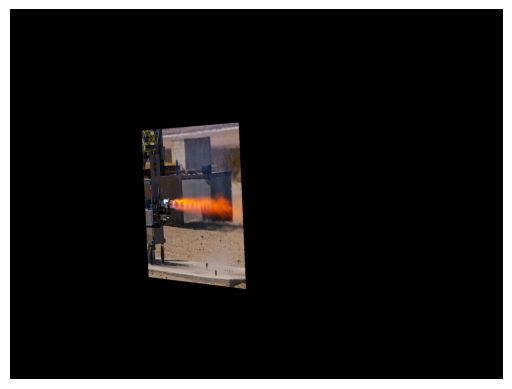

In [11]:
img3_warped = cv2.warpPerspective(img3, H_part2, (img1.shape[1], img1.shape[0]))
cv2.imwrite('Part 2 Images/warped_part2.png', img3_warped)


img3_warped_rgb = cv2.cvtColor(img3_warped, cv2.COLOR_BGR2RGB)
plt.imshow(img3_warped_rgb)
plt.axis('off')
plt.show()

The warped image looks good. Now we will paste it on top of the target image as before.

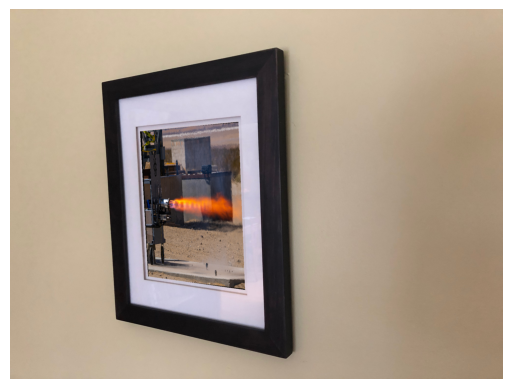

In [12]:
foreground = Image.open("Part 2 Images/warped_part2.png")
background = Image.open("HW2_image1.jpg")


background = ImageOps.mirror(background)
background = ImageOps.flip(background)
background.paste(foreground, (0,0), mask=mask_im)

# show and save the image
plt.imshow(background)
plt.axis('off')
plt.show()

background = background.rotate(180) # rotate the image back so we see it right side up
background.save("Part 2 Images/Part_2_Combined_Image.png")

# 3) 5 Image Mosaic

To produce the image mosaic, we begin by resizing all the images to be 5 images wide, but keeping each image in their respective place in the full panorama. This makes warping perspective later on easier. For the stitching process, I started with the center image, then moved right, combining the first right image, then taking that double image and combining it with the far right image. I then took those three and combined it with the middle left image, then finally took all four and added the far last image. Blending the images was done by first creating a mask out of the warped image, then using Pillow's paste function to add that to the background image with a mask to remove the surrounding pixels.

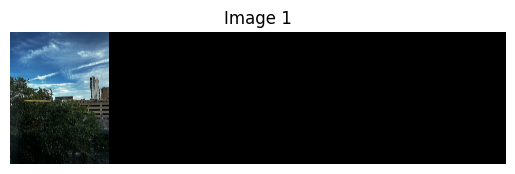

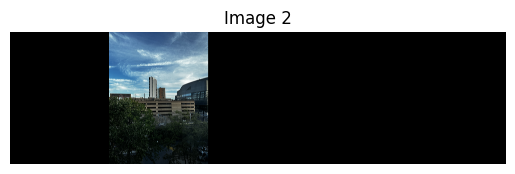

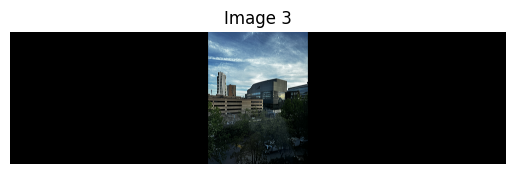

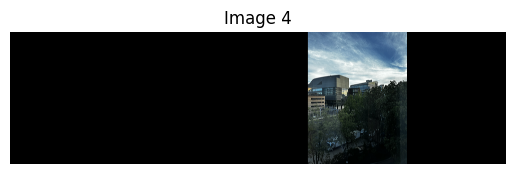

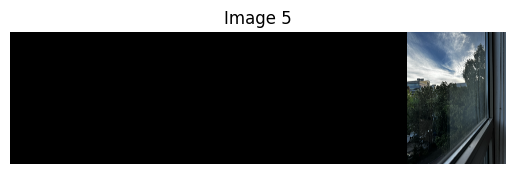

In [13]:
part_3_cv_images = []
border_padding_factors = {7040: [0, 4], 7041: [1, 3], 7042: [2, 2], 7043: [3, 1], 7044: [4, 0]} # dictates how much padding to add for each image

for i in range(7040, 7045):
    img = cv2.imread(f'Part 3 Images/IMG_{i}.png')

    # add padding to the sides of the images to make the final 5 image panorama to scale
    img = cv2.copyMakeBorder(img, 0, 0, border_padding_factors[i][0]* img.shape[1], border_padding_factors[i][1]* img.shape[1], cv2.BORDER_CONSTANT, value=(0, 0, 0))
    cv2.imwrite(f'Part 3 Images/resized_img{i-7039}.png', img)
    part_3_cv_images.append(img)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.title(f'Image {i-7039}')
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

Stitch 1

Center image and first right image.

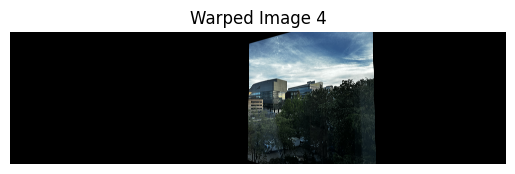

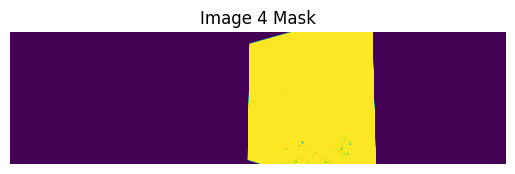

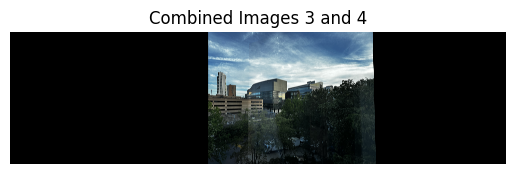

In [14]:
# source is img4 (right of center), destination is img3 (center)
# target / center image
img3to4_pts = np.array([
    (7466, 1785, 1),
    (9011, 1613, 1),
    (8845, 3284, 1),
    (7385, 2627, 1),
])

# source / right of center image
img4to3_pts = np.array([
    (9313, 1650, 1),
    (10821, 1555, 1),
    (10688, 3044, 1),
    (9229, 2588, 1),
])

# DLT algorithm to obtain A and H
A_4to3 = create_A(img4to3_pts, img3to4_pts)
H_4to3 = computeH(A_4to3)

# warping the image 
img4to3_warped = cv2.warpPerspective(part_3_cv_images[3], H_4to3, (part_3_cv_images[3].shape[1], part_3_cv_images[3].shape[0]))
cv2.imwrite('Part 3 Images/warped_img4to3.png', img4to3_warped)


plt.imshow(img4to3_warped[...,::-1])
plt.axis('off')
plt.title('Warped Image 4')
plt.show()

# creating a mask to paste the warped right image over the center image
img4to3_mask = cv2.imread('Part 3 Images/warped_img4to3.png', cv2.IMREAD_GRAYSCALE)
ret, img4to3_mask = cv2.threshold(img4to3_mask, 0, 255, cv2.THRESH_BINARY)
cv2.imwrite('Part 3 Images/mask_img4to3.png', img4to3_mask)


plt.imshow(img4to3_mask)
plt.axis('off')
plt.title('Image 4 Mask')
plt.show()

# combining both images by pasting one over the other
foreground = Image.open("Part 3 Images/warped_img4to3.png")
background = Image.open("Part 3 Images/resized_img3.png")
mask =  Image.open("Part 3 Images/mask_img4to3.png")
background.paste(foreground, (0,0), mask=mask)

background.save("Part 3 Images/combined34.png")

plt.imshow(background)
plt.axis('off')
plt.title('Combined Images 3 and 4')
plt.show()


Stitch 2

Combined center+right image with far right image.

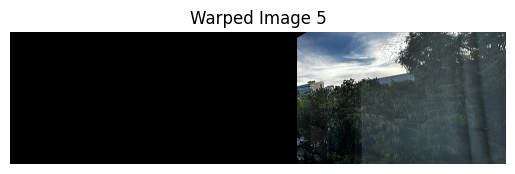

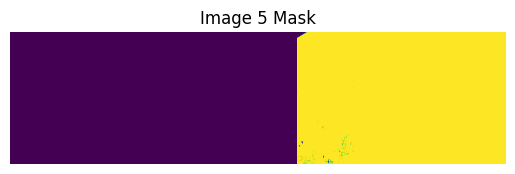

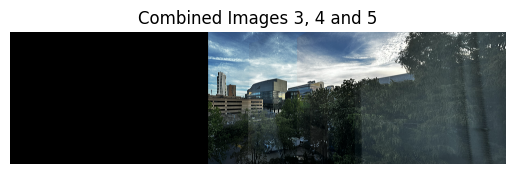

In [15]:
# target / combined center+right image
img34to5_pts = np.array([
    (8890, 1643, 1),
    (10827, 1404, 1),
    (10600, 3820, 1),
    (8845, 3283, 1),
])

# source / far right image
img5to34_pts = np.array([
    (12242, 1517, 1),
    (13457, 1541, 1),
    (13357, 3113, 1),
    (12195, 3163, 1),
])

A_5to34 = create_A(img5to34_pts, img34to5_pts)
H_5to34 = computeH(A_5to34)


img5to34_warped = cv2.warpPerspective(part_3_cv_images[4], H_5to34, (part_3_cv_images[4].shape[1], part_3_cv_images[4].shape[0]))
cv2.imwrite('Part 3 Images/warped_img5to34.png', img5to34_warped)



plt.imshow(img5to34_warped[...,::-1])
plt.axis('off')
plt.title('Warped Image 5')
plt.show()

img5to34_mask = cv2.imread('Part 3 Images/warped_img5to34.png', cv2.IMREAD_GRAYSCALE)
ret, img5to34_mask = cv2.threshold(img5to34_mask, 0, 255, cv2.THRESH_BINARY)
cv2.imwrite('Part 3 Images/mask_img5to34.png', img5to34_mask)


plt.imshow(img5to34_mask)
plt.axis('off')
plt.title('Image 5 Mask')
plt.show()

foreground = Image.open("Part 3 Images/warped_img5to34.png")
background = Image.open("Part 3 Images/combined34.png")
mask =  Image.open("Part 3 Images/mask_img5to34.png")
background.paste(foreground, (0,0), mask=mask)

background.save("Part 3 Images/combined345.png")

plt.imshow(background)
plt.axis('off')
plt.title('Combined Images 3, 4 and 5')
plt.show()

Stitch 3

Combined center+right+far right images with left image.

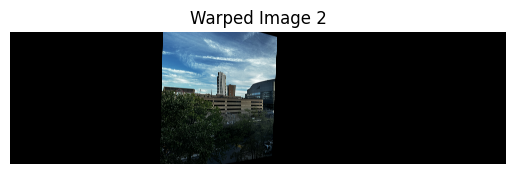

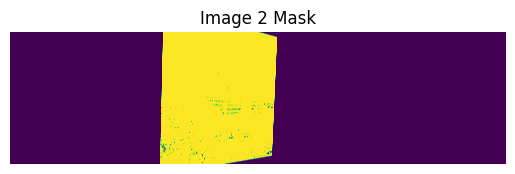

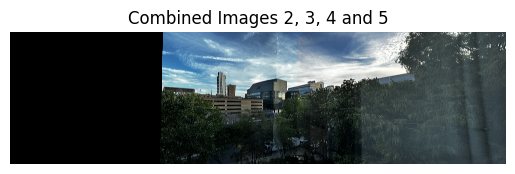

In [16]:
# target / combined center+right+far right image
img345to2_pts = np.array([
    (6348, 1236, 1),
    (7870, 1454, 1),
    (7944, 3635, 1),
    (6405, 3341, 1),
])

# source / left image
img2to345_pts = np.array([
    (4252, 1390, 1),
    (5779, 1430, 1),
    (5984, 3855, 1),
    (4362, 3348, 1),
])

A_2to345 = create_A(img2to345_pts, img345to2_pts)
H_2to345 = computeH(A_2to345)


img2to345_warped = cv2.warpPerspective(part_3_cv_images[1], H_2to345, (part_3_cv_images[1].shape[1], part_3_cv_images[1].shape[0]))
cv2.imwrite('Part 3 Images/warped_img2to345.png', img2to345_warped)



plt.imshow(img2to345_warped[...,::-1])
plt.axis('off')
plt.title('Warped Image 2')
plt.show()

img2to345_mask = cv2.imread('Part 3 Images/warped_img2to345.png', cv2.IMREAD_GRAYSCALE)
ret, img2to345_mask = cv2.threshold(img2to345_mask, 0, 255, cv2.THRESH_BINARY)
cv2.imwrite('Part 3 Images/mask_img2to345.png', img2to345_mask)


plt.imshow(img2to345_mask)
plt.axis('off')
plt.title('Image 2 Mask')
plt.show()

foreground = Image.open("Part 3 Images/warped_img2to345.png")
background = Image.open("Part 3 Images/combined345.png")
mask =  Image.open("Part 3 Images/mask_img2to345.png")
background.paste(foreground, (0,0), mask=mask)

background.save("Part 3 Images/combined2345.png")

plt.imshow(background)
plt.axis('off')
plt.title('Combined Images 2, 3, 4 and 5')
plt.show()

Stitch 4

Combined left+center+right+far right images with far left image.

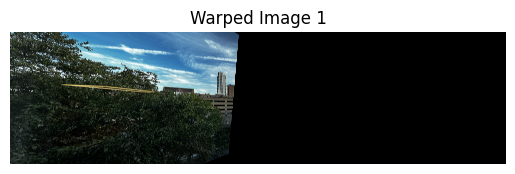

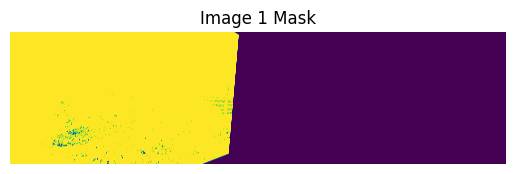

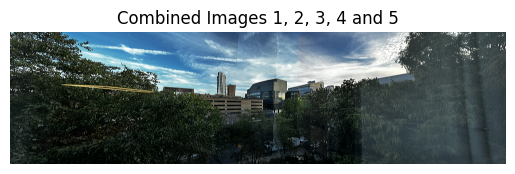

In [17]:
# target / combined left+center+right+far right image
img2345to1_pts = np.array([
    (4682, 1686, 1),
    (6530, 1289, 1),
    (6755, 2536, 1),
    (5293, 3893, 1),
])

# source / far left image
img1to2345_pts = np.array([
    (1380, 1999, 1),
    (2641, 1404, 1),
    (3008, 2701, 1),
    (1821, 3729, 1),
])

A_1to2345 = create_A(img1to2345_pts, img2345to1_pts)
H_1to2345 = computeH(A_1to2345)


img1to2345_warped = cv2.warpPerspective(part_3_cv_images[0], H_1to2345, (part_3_cv_images[0].shape[1], part_3_cv_images[0].shape[0]))
cv2.imwrite('Part 3 Images/warped_img1to2345.png', img1to2345_warped)



plt.imshow(img1to2345_warped[...,::-1])
plt.axis('off')
plt.title('Warped Image 1')
plt.show()

img1to2345_mask = cv2.imread('Part 3 Images/warped_img1to2345.png', cv2.IMREAD_GRAYSCALE)
ret, img1to2345_mask = cv2.threshold(img1to2345_mask, 0, 255, cv2.THRESH_BINARY)
cv2.imwrite('Part 3 Images/mask_img1to2345.png', img1to2345_mask)


plt.imshow(img1to2345_mask)
plt.axis('off')
plt.title('Image 1 Mask')
plt.show()

foreground = Image.open("Part 3 Images/warped_img1to2345.png")
background = Image.open("Part 3 Images/combined2345.png")
mask =  Image.open("Part 3 Images/mask_img1to2345.png")
background.paste(foreground, (0,0), mask=mask)

background.save("Part 3 Images/combined12345.png")

plt.imshow(background)
plt.axis('off')
plt.title('Combined Images 1, 2, 3, 4 and 5')
plt.show()

The image below shows the full panorama with all 5 images. 

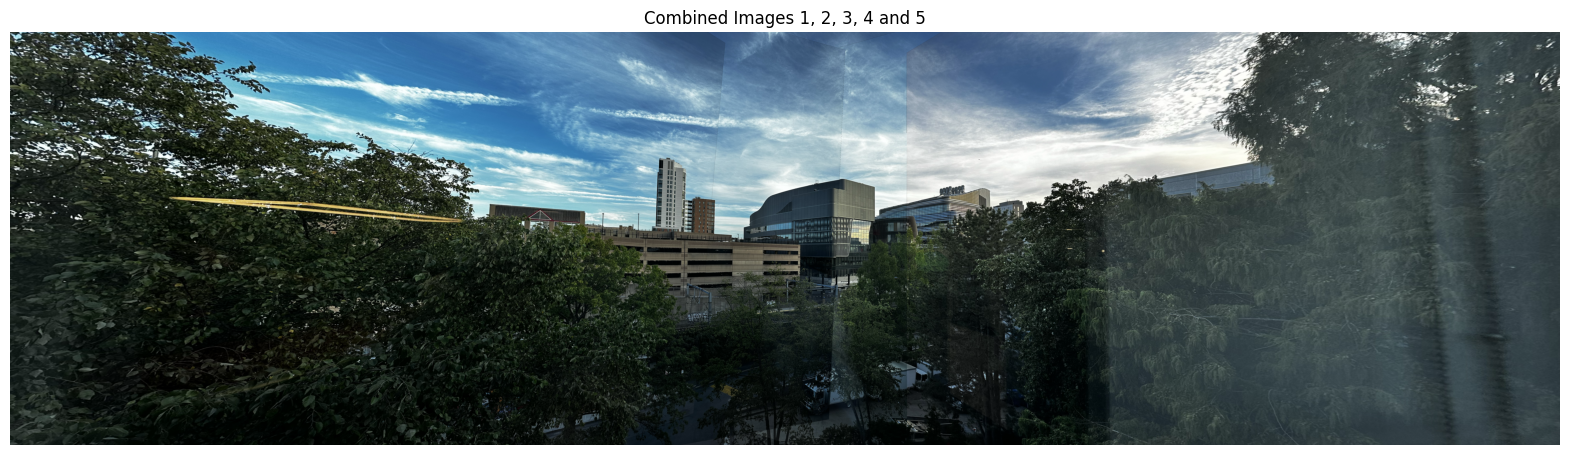

In [18]:
plt.figure(figsize=(20,30))
plt.imshow(background)
plt.axis('off')
plt.title('Combined Images 1, 2, 3, 4 and 5')
plt.show()

Comparing addWeighted with pyramid blending

The addWeighted method is essentially a weighted average of two images pixel values. It applies the same weights to all the pixels of both images and results in one image being overlaid onto the other. With pyramid blending, downsampled versions of the images are created at multiple scale levels. These sub images are made using Laplacian operators, which result in smaller and smoother images. The pyramids for both images are blended at each level individually, then the combined pyramid is collapsed to get the final image. Pyramid blending is a more advanced technique and results in blends that are seamless and can have smooth transitions between images, which addWeighted simply doesn't allow. 